### ZNE Run
- Compare effectiveness of of ZNE + Gate Twirling using the ZNE-heuristic
- Efficient-SU2 circuit with 4096 shots x3 (for averaging)
- Batch mode suitable with PUB as [(isa_ghz, isa_observable)] 
- Normal Transpilation (isa_ghz) :- Transpiling for backend with optimization_level = 3

In [81]:
import sys
import os

# Add project root (one level up from 'notebooks')
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [82]:
# email: uthuppukurian@gmail.com

token = "zh1lkXLoFZSN2PXRYM1VnjYJTW3Q1PCjhEROLC_cmtU4"

from qiskit_ibm_runtime import QiskitRuntimeService

QiskitRuntimeService.save_account(
    token=token,
    instance="crn:v1:bluemix:public:quantum-computing:us-east:a/858d1cfb46bf4703b9189b11b4f9cbfa:3cb3ee53-f86c-4e7b-972a-1ce9eb93bb89::",
    channel="ibm_quantum_platform",
    overwrite=True,
    set_as_default=True,
    name="qamp-2025",
)

In [83]:
from qiskit import QuantumCircuit
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    EstimatorV2 as Estimator,
    EstimatorOptions,
    Batch,
)
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import efficient_su2
from qiskit_aer.primitives import EstimatorV2 as AerEstimator, SamplerV2 as AerSampler
from qiskit_aer import AerSimulator
from qiskit.primitives import BackendEstimatorV2
from adaptive_error_mitigation.analytics import (
    extract_basic_features,
    extract_backend_metrics,
    calculate_derived_noise_metrics,
)
from qiskit.providers.backend import BackendV2 as Backend
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [84]:
def gen_param4_eff_su2(n_qubits: int, seed: int, reps: int = 1):
    np.random.seed(seed)
    arr = np.random.normal(loc=0, scale=0.22, size=n_qubits*reps*4)
    return arr

def prepare_eff_su2(n_qubits: int, params: list):
    crkt = efficient_su2(num_qubits=n_qubits, reps=1, entanglement="linear")
    eff_su2_crkt = crkt.assign_parameters(params)
    return eff_su2_crkt

def naked_estimator(mode):
    ## Estimator with no error mitigation or supression for any mode (job, batch). ALL OPTIONS ARE DISABLED.
    config_est_options = {
        "dynamical_decoupling": {"enable": False},
        "twirling": {"enable_gates": False, "enable_measure": False},
        "resilience_level": 0,
        "resilience": {
            "zne_mitigation": False,
        },
    }

    estimator_options = EstimatorOptions(**config_est_options)
    estimator = Estimator(mode=mode, options=estimator_options)
    return estimator


def zne_gt_estimator(mode):
    ## Estimator with no error mitigation or supression for any mode (job, batch). ALL OPTIONS ARE DISABLED.
    config_est_options = {
        "dynamical_decoupling": {"enable": False},
        "twirling": {"enable_gates": True, "enable_measure": False},
        "resilience_level": 0,
        "resilience": {
            "zne_mitigation": True,
            "zne": {
                "amplifier": "gate_folding",
                "noise_factors": (1, 3, 5),
                "extrapolator": "exponential",
            },
        },
    }

    estimator_options = EstimatorOptions(**config_est_options)
    estimator = Estimator(mode=mode, options=estimator_options)
    return estimator


def pm_for_backend(bknd, opt_level=3, seed=42069):
    ## Returns a PassManager from generate_preset_pass_manager for given opt_level and backend(bknd)
    pm = generate_preset_pass_manager(
        optimization_level=opt_level,
        backend=bknd,
        seed_transpiler=seed,
    )
    return pm


def create_isa_observables(isa_circuit_dict, pauli_char="Z"):
    ## Returns a dict of ISA observables with layouts applied, matching the input isa_circuit_dict keys.
    isa_observables = {}

    for key, isa_qc in isa_circuit_dict.items():
        # 1. Parse qubit count from key
        num_qubits = int(key)

        # 2. Create the logical observable (e.g., "ZZZ")
        observable = SparsePauliOp(pauli_char * num_qubits)

        # 3. Apply the layout from the transpiled circuit
        isa_obs = observable.apply_layout(isa_qc.layout)

        isa_observables[key] = isa_obs

    return isa_observables


def transpile_for_dd(circuit, dd_pm):
    isa_dd_circuit = dd_pm.run(circuit)
    return isa_dd_circuit


def get_h_zne(qc, backend):
    # 1. Extract required metrics using your helper functions
    qubits_used = extract_basic_features(qc)["qubits_used"]
    ons = calculate_derived_noise_metrics(qc, backend)["overall_noise_sensitivity"]
    t2_avg = extract_backend_metrics(qc, backend)["avg_t2_time"]

    # 2. Get circuit duration from the backend target
    duration_ns = qc.estimate_duration(backend.target)

    # 3. Calculate H_ZNE (Handling division by zero)
    if t2_avg == 0:
        return 0.0

    h_zne = ons + qubits_used * (duration_ns / t2_avg)
    return h_zne

In [85]:
# Backend
service = QiskitRuntimeService(name="qamp-2025")
bknd_fez = service.backend("ibm_fez")

management.get:WARNING:2025-12-08 16:05:21,390: Loading saved account: qamp-2025


In [86]:
QUBIT_SEED = [
    (5, 3648),
    (12, 9158),
    (20, 3863),
    (30, 1631),
    (37, 8508),
]

In [87]:
params_dict = {
    f"{n_qubits}": gen_param4_eff_su2(n_qubits, seed) for n_qubits, seed in QUBIT_SEED
}

In [88]:
## Prepare circuit dict
circuit_dict = {
    n_qubits: prepare_eff_su2(n_qubits=int(n_qubits), params=params)
    for n_qubits, params in params_dict.items()
}
circuit_dict

{'5': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x26afc152050>,
 '12': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x26ae26e0bd0>,
 '20': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x26ae26e3e50>,
 '30': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x26ae259ff10>,
 '37': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x26ae259d950>}

In [89]:
## Transpiler with optimization_level=3
pm3 = pm_for_backend(bknd_fez)
isa_dict = {
    f"{n_qubits}": pm3.run(circuit_dict[f"{n_qubits}"]) for n_qubits, _ in QUBIT_SEED
}

In [90]:
crkt_depth_dict = {
    f"{key}": extract_basic_features(isa_qc)["depth"]
    for key, isa_qc in isa_dict.items()
}
crkt_depth_dict

{'5': 19, '12': 40, '20': 64, '30': 94, '37': 115}

In [91]:
cnt_1q_dict = {
    f"{key}": extract_basic_features(isa_qc)["num_1q_gates"]
    for key, isa_qc in isa_dict.items()
}
cnt_1q_dict

{'5': 51, '12': 127, '20': 215, '30': 325, '37': 402}

In [92]:
cnt_2q_dict = {
    f"{key}": extract_basic_features(isa_qc)["num_2q_gates"]
    for key, isa_qc in isa_dict.items()
}
cnt_2q_dict

{'5': 4, '12': 11, '20': 19, '30': 29, '37': 36}

In [93]:
per_qubit_2q_dict = {
    f"{key}": round(extract_basic_features(isa_qc)["num_2q_gates"] / int(key), 3)
    for key, isa_qc in isa_dict.items()
}
per_qubit_2q_dict

{'5': 0.8, '12': 0.917, '20': 0.95, '30': 0.967, '37': 0.973}

In [94]:
h_zne_dict = {f"{key}": get_h_zne(isa_qc, bknd_fez) for key, isa_qc in isa_dict.items()}
h_zne_dict

{'5': 0.03567963759052672,
 '12': 0.1822706136453527,
 '20': 0.41589455073463155,
 '30': 0.8756909471988785,
 '37': 1.3584203751503283}

In [95]:
obs_isa_dict = create_isa_observables(isa_dict, pauli_char="Z")

In [96]:
## Simulate on Aer Simulator
mps_backend = AerSimulator(method="matrix_product_state")
aer_estimator = BackendEstimatorV2(backend=mps_backend)

aer_pub = [
    (isa_dict[f"{n_qubit}"], obs_isa_dict[f"{n_qubit}"]) for n_qubit, _ in QUBIT_SEED
]

for n_qubit, _ in QUBIT_SEED:
    aer_job = aer_estimator.run(aer_pub)
    aer_result = aer_job.result()

ideal_est = {f"{n}": res.data.evs for (n, _), res in zip(QUBIT_SEED, aer_result)}
ideal_est

{'5': array(0.93359375),
 '12': array(0.48291016),
 '20': array(0.39941406),
 '30': array(0.4453125),
 '37': array(0.20458984)}

In [97]:
pub_hardware_dict = {f"{n}": [isa_dict[f"{n}"]] for n, _ in QUBIT_SEED}
pub_hardware_dict

{'5': [<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x26ae188ab10>],
 '12': [<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x26ae188a910>],
 '20': [<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x26ae2e11790>],
 '30': [<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x26ae1f09e50>],
 '37': [<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x26ae1f09790>]}

In [98]:
# --- 1. PREPARATION ---
all_pubs = []
result_map = []

# Iterate through your hardware dictionary
for qubit_count, circuit_list in pub_hardware_dict.items():

    # Get the observable for this specific qubit count
    # (We assume obs_isa_dict has keys like '5', '11', etc.)
    current_obs = obs_isa_dict[qubit_count]

    for i, circ in enumerate(circuit_list):
        # Safety: Sanitize Name
        circ.name = f"{qubit_count}q_isa_only"

        # Create PUB: (Circuit, Observable)
        pub = (circ, current_obs)
        all_pubs.append(pub)

        # Store metadata
        # Since you have no DD methods, we hardcode 'method' to 'Standard'
        result_map.append({"qubits": qubit_count, "method": "Standard_ISA"})

print(f"Total PUBs per job: {len(all_pubs)}")

Total PUBs per job: 5


In [ ]:
# # Store job objects to retrieve results later
# batch_jobs = []
# NUM_ITRS = 3

# # Open the Batch Context
# with Batch(backend=bknd_fez) as batch:
#     # Initialize Estimator with the batch context
#     nake_est = naked_estimator(mode=batch)
#     zne_gt_est =zne_gt_estimator(mode=batch)

#     # 3. Loop for the iterations
#     for i in range(NUM_ITRS):

#         # Submit ALL pubs in ONE job
#         # Note: all_pubs is already a list of (circuit, observable) tuples
#         job = nake_est.run(all_pubs)
#         id = job.job_id()
#         print(f"Submitted Job-ID for iteration {i+1}/{NUM_ITRS}...: {id}")
#         batch_jobs.append(job)

#         job = zne_gt_est.run(all_pubs)
#         id = job.job_id()
#         print(f"Submitted Job-ID for iteration {i+1}/{NUM_ITRS}...: {id}")
#         batch_jobs.append(job)

# print("All jobs submitted. Waiting for results...")

Submitted Job-ID for iteration 1/3...: d4rak07t3pms73981c50
Submitted Job-ID for iteration 1/3...: d4rak0bher1c73bc3770
Submitted Job-ID for iteration 2/3...: d4rak0k5fjns73d176pg
Submitted Job-ID for iteration 2/3...: d4rak0vt3pms73981c70
Submitted Job-ID for iteration 3/3...: d4rak0rher1c73bc3780
Submitted Job-ID for iteration 3/3...: d4rak145fjns73d176qg
All jobs submitted. Waiting for results...


In [ ]:
# batch_jobs = []
# jobs = [
#     "d4rak07t3pms73981c50",
#     "d4rak0bher1c73bc3770",
#     "d4rak0k5fjns73d176pg",
#     "d4rak0vt3pms73981c70",
#     "d4rak0rher1c73bc3780",
#     "d4rak145fjns73d176qg",
# ]
# for job_id in jobs:
#     job = service.job(job_id=job_id)
#     batch_jobs.append(job)

In [101]:
import pandas as pd

# --- 3. ANALYSIS ---
plot_data = []

print(f"Processing {len(batch_jobs)} jobs...")

for global_idx, job in enumerate(batch_jobs):

    # --- LOGIC: EVEN = Naked, ODD = ZNE ---
    is_zne = global_idx % 2 != 0
    mitigation_type = "With_ZNE_GT" if is_zne else "No_ZNE"

    # Calculate Iteration Number (e.g., Job 0&1 = Itr 1, Job 2&3 = Itr 2)
    iteration_num = (global_idx // 2) + 1

    try:
        # Get results (blocks until ready)
        pub_results = job.result()
        current_job_id = job.job_id()
    except Exception as e:
        print(f"Job {job.job_id()} failed: {e}")
        continue

    # Process each qubit result within the job
    for i, pub_result in enumerate(pub_results):
        meta = result_map[i]

        q_count = meta["qubits"]
        q_str = str(q_count)  # Ensure key is string for dict lookups

        # 1. Get Values
        ev_exp = float(pub_result.data.evs)
        ev_ideal = float(ideal_est[q_str])  # Uses your ideal dictionary

        # 2. Calculate Error
        abs_error = abs(ev_exp - ev_ideal)

        # 3. Retrieve Physics Metrics (Safety .get used in case key is missing)
        # Note: Ensure cd_isa_qc_dict and max_dec_isa_qc_dict exist from previous steps
        crkt_depth = crkt_depth_dict.get(q_str, 0)
        cnt_1q = cnt_1q_dict.get(q_str, 0)
        cnt_2q = cnt_2q_dict.get(q_str, 0)
        h_zne = h_zne_dict.get(q_str, 0)
        per_qubit_2q = per_qubit_2q_dict.get(q_str, 0)

        # 4. Create Label
        label = f"{q_str}q ({mitigation_type})"

        plot_data.append(
            {
                "Label": label,
                "Qubits": int(q_count),
                "Iteration": iteration_num,
                "Mitigation": mitigation_type,
                "Abs_Error": abs_error,
                "Exp_Value": ev_exp,
                "Ideal_Value": ev_ideal,
                "Circuit Depth": crkt_depth,
                "Count 1q gates": cnt_1q,
                "Count 2q gates": cnt_2q,
                "ZNE_Heuristic": h_zne,
                "Cnt 2q per qubit": per_qubit_2q,
                "Job_ID": current_job_id,
            }
        )

# Create DataFrame
df = pd.DataFrame(plot_data)

# Sort: Qubits -> Mitigation (No_ZNE first) -> Iteration
df = df.sort_values(by=["Qubits", "Mitigation", "Iteration"]).reset_index(drop=True)

print("Analysis Complete.")
df.head()

Processing 6 jobs...
Analysis Complete.


,Label,Qubits,Iteration,Mitigation,Abs_Error,Exp_Value,Ideal_Value,Circuit Depth,Count 1q gates,Count 2q gates,ZNE_Heuristic,Cnt 2q per qubit,Job_ID
0,5q (No_ZNE),5,1,No_ZNE,0.103516,0.830078,0.933594,19,51,4,0.03568,0.8,d4rak07t3pms73981c50
1,5q (No_ZNE),5,2,No_ZNE,0.106934,0.826660,0.933594,19,51,4,0.03568,0.8,d4rak0k5fjns73d176pg
2,5q (No_ZNE),5,3,No_ZNE,0.105469,0.828125,0.933594,19,51,4,0.03568,0.8,d4rak0rher1c73bc3780
3,5q (With_ZNE_GT),5,1,With_ZNE_GT,0.073811,0.859782,0.933594,19,51,4,0.03568,0.8,d4rak0bher1c73bc3770
4,5q (With_ZNE_GT),5,2,With_ZNE_GT,0.121620,0.811974,0.933594,19,51,4,0.03568,0.8,d4rak0vt3pms73981c70


In [102]:
# Saves the file to the same folder as your notebook
df.to_csv("ZNE_GT_B_Est_EffSU2_6.csv", index=False)

In [104]:
# 1. Create a list of the dataframes you want to combine
frames = [df]

# 2. Concatenate them
# ignore_index=True ensures the index resets to 0, 1, 2... continuously
df = pd.concat(frames, ignore_index=True)

# 3. (Optional but Recommended) Re-sort so the new data sits in the right place
df = df.sort_values(by=["Qubits", "Mitigation", "Iteration"]).reset_index(drop=True)

# Check the result
print(f"New shape: {df.shape}")
df.head()

New shape: (30, 13)


,Label,Qubits,Iteration,Mitigation,Abs_Error,Exp_Value,Ideal_Value,Circuit Depth,Count 1q gates,Count 2q gates,ZNE_Heuristic,Cnt 2q per qubit,Job_ID
0,5q (No_ZNE),5,1,No_ZNE,0.103516,0.830078,0.933594,19,51,4,0.03568,0.8,d4rak07t3pms73981c50
1,5q (No_ZNE),5,2,No_ZNE,0.106934,0.826660,0.933594,19,51,4,0.03568,0.8,d4rak0k5fjns73d176pg
2,5q (No_ZNE),5,3,No_ZNE,0.105469,0.828125,0.933594,19,51,4,0.03568,0.8,d4rak0rher1c73bc3780
3,5q (With_ZNE_GT),5,1,With_ZNE_GT,0.073811,0.859782,0.933594,19,51,4,0.03568,0.8,d4rak0bher1c73bc3770
4,5q (With_ZNE_GT),5,2,With_ZNE_GT,0.121620,0.811974,0.933594,19,51,4,0.03568,0.8,d4rak0vt3pms73981c70


In [105]:
# Keep rows where Abs_Error is LESS than or equal to 2
df = df[df["Abs_Error"] <= 2]

# Reset the index to avoid gaps
df = df.reset_index(drop=True)

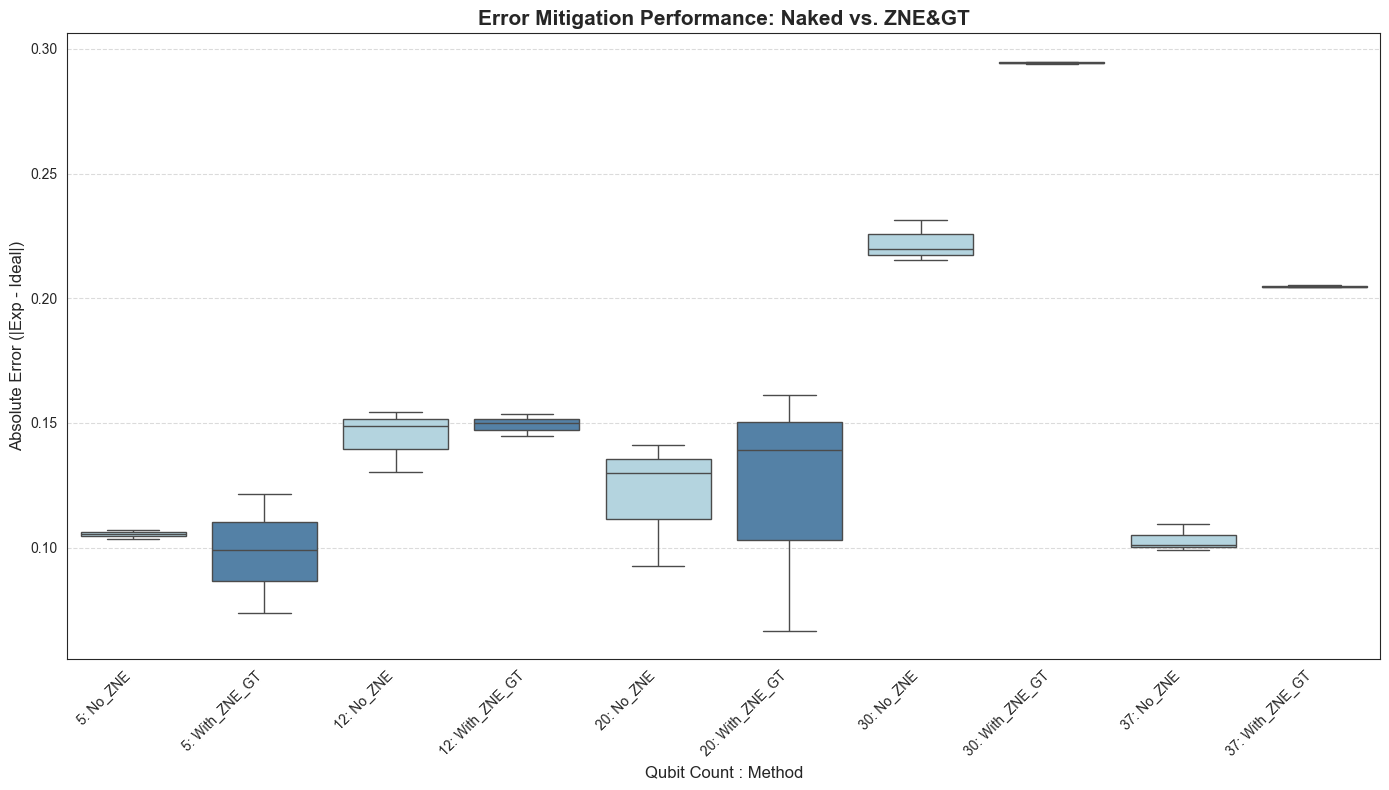

In [106]:
# 1. Data Preparation
# Create a combined label column: e.g., "3: No_ZNE", "3: With_ZNE"
df["Label"] = df["Qubits"].astype(str) + ": " + df["Mitigation"]

# Sort the dataframe so the X-axis is ordered logically (by Qubits, then by Mitigation)
# This ensures 2 qubits comes before 10 qubits, etc.
df = df.sort_values(by=["Qubits", "Mitigation"])

# 2. Setup Figure
plt.figure(figsize=(14, 8))
sns.set_style("white")  # Cleaner background like the template

# 3. Define Colors and Palette Logic
# Mapping your specific categories to the template's colors
# No_ZNE -> Light Blue (Baseline), With_ZNE -> Steel Blue (Mitigated)
color_map = {"No_ZNE": "#ADD8E6", "With_ZNE_GT": "#4682B4"}

unique_labels = df["Label"].unique()
# This list comprehension ensures the colors match the sorted order of the labels
palette_list = [color_map[label.split(": ")[1]] for label in unique_labels]

# 4. Create the Box Plot
sns.boxplot(
    data=df,
    x="Label",
    y="Abs_Error",
    hue="Label",  # Assign hue to Label to apply the palette
    palette=palette_list,
    dodge=False,  # Prevents grouping/shifting
    legend=False,  # Legend is redundant because x-axis labels explain it
    fliersize=3,  # Keep outlier dots small
)

# 5. Titles and Labels
plt.title(
    "Error Mitigation Performance: Naked vs. ZNE&GT", fontsize=15, fontweight="bold"
)
plt.xlabel("Qubit Count : Method", fontsize=12)
plt.ylabel("Absolute Error (|Exp - Ideal|)", fontsize=12)

# 6. Adjust Axes and Grid (Matching the template style)
# Dynamic Y-limits with a small buffer
min_y = df["Abs_Error"].min()
max_y = df["Abs_Error"].max()
# Add 5% buffer to top and bottom
buffer = (max_y - min_y) * 0.05
plt.ylim(min_y - buffer, max_y + buffer)

# Grid only on Y-axis
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Rotate x-labels for readability
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.savefig("zne_comparison_flat.png", dpi=300)
plt.show()

In [107]:
# 1. Group by Qubits and Mitigation to get the MEAN Absolute Error across iterations
df_avg = df.groupby(["Qubits", "Mitigation"])["Abs_Error"].mean().unstack()

# 2. Calculate "Improvement" (Positive means ZNE reduced the error)
df_avg["Improvement"] = df_avg["No_ZNE"] - df_avg["With_ZNE_GT"]

# 3. Map your Custom Metrics
df_avg["H_ZNE"] = df.groupby("Qubits")["ZNE_Heuristic"].first()
df_avg["Cnt_2Q_Per_Qubit"] = df.groupby("Qubits")["Cnt 2q per qubit"].first()

# Reset index so 'Qubits' becomes a regular column for plotting
df_analysis = df_avg.reset_index()

# Check the data
print(df_analysis[["Qubits", "Improvement", "H_ZNE", "Cnt_2Q_Per_Qubit"]])

Mitigation  Qubits  Improvement     H_ZNE  Cnt_2Q_Per_Qubit
0                5     0.007155  0.035680             0.800
1               12    -0.004866  0.182271             0.917
2               20    -0.001075  0.415895             0.950
3               30    -0.072298  0.875691             0.967
4               37    -0.101629  1.358420             0.973


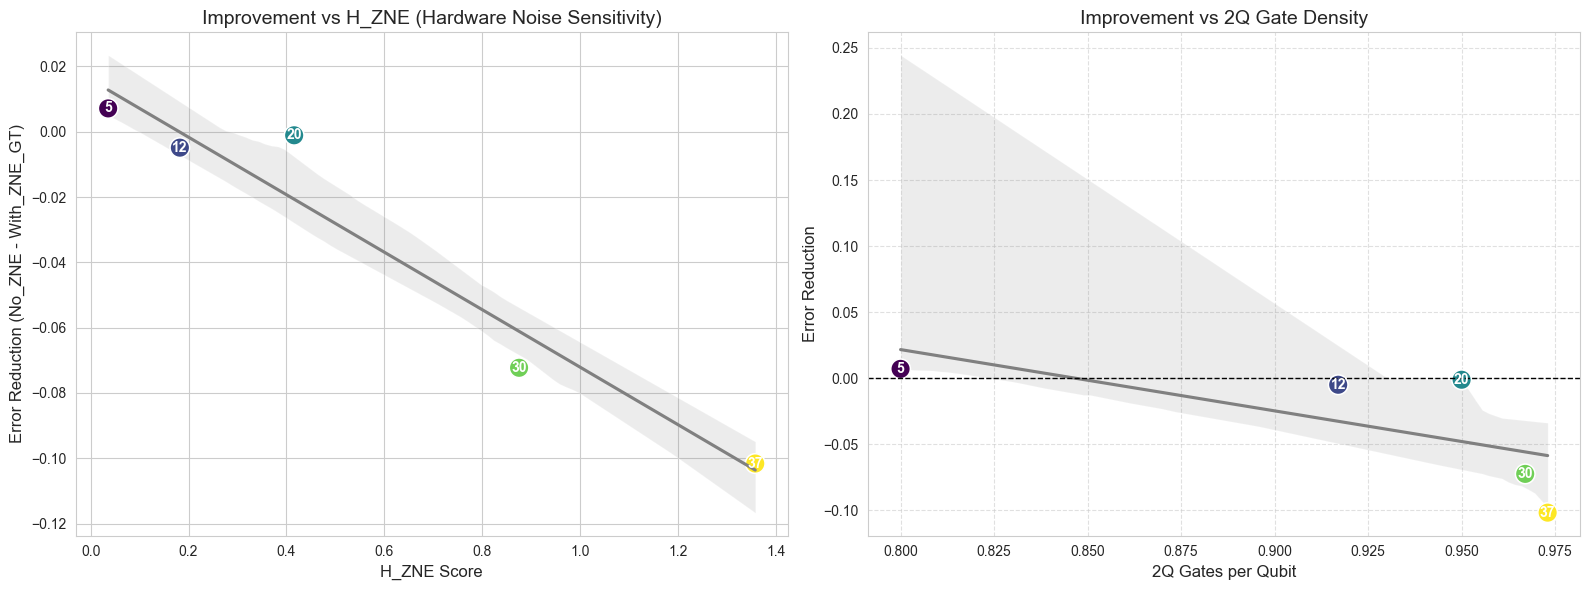

In [109]:
# Setup the figure
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.set_style("whitegrid")

# --- PLOT 1: Improvement vs H_ZNE ---
sns.regplot(
    data=df_analysis,
    x="H_ZNE",
    y="Improvement",
    ax=axes[0],
    color="gray",
    scatter=False,
    ci=80,
)

# Add the colored dots (Scatter)
sns.scatterplot(
    data=df_analysis,
    x="H_ZNE",
    y="Improvement",
    hue="Qubits",
    palette="viridis",
    s=200,
    ax=axes[0],
    legend=False,
)

# Add qubit numbers inside bubbles
for idx, row in df_analysis.iterrows():
    axes[0].text(
        row["H_ZNE"],
        row["Improvement"],
        s=f"{int(row['Qubits'])}",
        ha="center",
        va="center",
        fontsize=10,
        fontweight="bold",
        color="white",
    )

axes[0].set_title("Improvement vs H_ZNE (Hardware Noise Sensitivity)", fontsize=14)
axes[0].set_xlabel("H_ZNE Score", fontsize=12)
axes[0].set_ylabel("Error Reduction (No_ZNE - With_ZNE_GT)", fontsize=12)

# --- PLOT 2: Improvement vs 2Q Gates per Qubit ---
sns.regplot(
    data=df_analysis,
    x="Cnt_2Q_Per_Qubit",
    y="Improvement",
    ax=axes[1],
    color="gray",
    scatter=False,
    ci=80,
)

sns.scatterplot(
    data=df_analysis,
    x="Cnt_2Q_Per_Qubit",
    y="Improvement",
    hue="Qubits",
    palette="viridis",
    s=200,
    ax=axes[1],
    legend=False,
)

# Add qubit numbers inside bubbles
for idx, row in df_analysis.iterrows():
    axes[1].text(
        row["Cnt_2Q_Per_Qubit"],
        row["Improvement"],
        s=f"{int(row['Qubits'])}",
        ha="center",
        va="center",
        fontsize=10,
        fontweight="bold",
        color="white",
    )

axes[1].set_title("Improvement vs 2Q Gate Density", fontsize=14)
axes[1].set_xlabel("2Q Gates per Qubit", fontsize=12)
axes[1].set_ylabel("Error Reduction", fontsize=12)
axes[1].grid(True, linestyle="--", alpha=0.6)
axes[1].axhline(0, color="black", linewidth=1, linestyle="--")

plt.tight_layout()
plt.show()